In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, ParameterGrid
from metrics import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None  # Suppress the warning


In [49]:
def split_by_session(data, test_size=0.2, random_state=42):
    # Get unique sessions
    unique_sessions = data['impression_id'].unique()

    # Split sessions into train and test
    train_sessions, test_sessions = train_test_split(unique_sessions,
                                                    test_size=test_size,
                                                    random_state=random_state)

    # Create train and test sets
    train_data = data[data['impression_id'].isin(train_sessions)]
    test_data = data[data['impression_id'].isin(test_sessions)]

    return train_data, test_data

In [ ]:
df = pd.read_parquet("train_dataset_ebnerd_small.parquet")
train_data, validation_data = split_by_session(df, test_size = 0.2)
test_data = pd.read_parquet("test_dataset_ebnerd_small.parquet")
print(len(train_data), len(validation_data), len(test_data))


1507242 375276 703229


In [ ]:
import pandas as pd
import xgboost as xgb

# Assuming train_data, validation_data, and test_data are your DataFrames
target = ["clicked"]
ids = ["impression_id", "session_id", "article_id", "user_id"]
excluded_columns = target + ids

# Step 1: Identify categorical columns
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns.tolist()
feature_list = [col for col in train_data.columns if col not in excluded_columns]

# Step 2: Combine feature_list with categorical_columns to ensure we're encoding them correctly
feature_list = list(set(feature_list + categorical_columns))
print("Features used for modeling:", feature_list)

# Prepare training data
X_train = pd.get_dummies(train_data[feature_list], drop_first=True)
y_train = train_data['clicked'].values
X_train['qid'] = train_data['impression_id'] 

# Prepare validation data
X_val = pd.get_dummies(validation_data[feature_list], drop_first=True)
X_val = X_val.reindex(columns=X_train.columns[:-1], fill_value=0) 
y_val = validation_data['clicked'].values
X_val['qid'] = validation_data['impression_id'] 
# Prepare test data
X_test = pd.get_dummies(test_data[feature_list], drop_first=True)
X_test = X_test.reindex(columns=X_train.columns[:-1], fill_value=0)  
y_test = test_data['clicked'].values
X_test['qid'] = test_data['impression_id']

dtrain = xgb.DMatrix(X_train.drop(columns=['qid']), label=y_train, qid=X_train['qid'])
dval = xgb.DMatrix(X_val.drop(columns=['qid']), label=y_val, qid=X_val['qid'])
dtest = xgb.DMatrix(X_test.drop(columns=['qid']), label=y_test, qid=X_test['qid'])


Features used for modeling: ['is_subscriber', 'origin_current_diff_published', 'user_article_least_favorite', 'is_sso_user', 'sentiment_label', 'user_article_same_mood', 'cluster', 'origin_sentiment_score', 'device_type', 'origin_current_diff_sentiment_score', 'user_average_scroll_percentage', 'user_average_read_time', 'coming_from_home_page', 'origin_current_same_sentiment_label', 'origin_current_diff_impression_published', 'user_article_favorite', 'user_mood', 'user_impression_frequency', 'time_of_day', 'origin_scroll_percentage', 'origin_read_time', 'origin_current_same_cluster', 'user_interaction_score', 'origin_cluster', 'origin_current_same_category', 'sentiment_score', 'origin_sentiment_label', 'premium']


In [ ]:
from sklearn.model_selection import ParameterGrid
import xgboost as xgb
# Hyperparameter grid for tuning
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Tracking the best model and score
best_score = -float('inf')
best_params = None

early_stopping_rounds= 10

stop_after = 1000
iterations = 0
for params in tqdm(ParameterGrid(param_grid, )):
    iterations += 1
    model = xgb.train(
        params={
            'objective': 'rank:ndcg',
            'lambdarank_num_pair_per_sample': '3', # Specify ndcg 3 as our objective function
            'eval_metric': 'ndcg@3',  # Evaluation ranking for early stopping
            **params
        },
        dtrain=dtrain,
        num_boost_round=500, 
        evals=[(dval, 'validation')], 
        early_stopping_rounds=early_stopping_rounds, # stops if no improvement after 10 rounds
        verbose_eval=False  
    )
    
    y_pred_valid = model.predict(dval)
    validation_data.loc[:, 'predicted_score'] = y_pred_valid
    ndcg_score = calculate_ndcg(validation_data, k=3)  # Custom function for NDCG
    # Update the best score and parameters if the current score is higher
    if ndcg_score > best_score:
        best_score = ndcg_score
        best_params = params


    if iterations > stop_after:
        print("Testing done")
        break

print("Best Parameters:", best_params)
print("Best Validation NDCG@3:", best_score)


100%|██████████| 72/72 [15:34<00:00, 12.98s/it]

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 1.0}
Best Validation NDCG@3: 1.0


In [53]:
# Step 1: Combine train and validation data
X_combined = pd.concat([X_train, X_val], axis=0)
y_combined = np.concatenate([y_train, y_val])
qid_combined = pd.concat([train_data['impression_id'], validation_data['impression_id']], axis=0)

# Step 2: Create DMatrix with qid for combined data
dcombined = xgb.DMatrix(X_combined, label=y_combined)
dcombined.set_group(qid_combined.groupby(qid_combined).size().to_list())  # Set qid as group size list

# Step 3: Train final model with best hyperparameters on combined data
final_model = xgb.train(
    params={
        'objective': 'rank:pairwise',
        'eval_metric': 'ndcg',
        **best_params
    },
    dtrain=dcombined,
    num_boost_round=500,  # Set a high number for best result
    verbose_eval=True
)

# Step 4: Generate predictions on test data using DMatrix
dtest = xgb.DMatrix(X_test)
y_pred_test = final_model.predict(dtest)

# Optionally add predictions to test DataFrame
test_data['predicted_score'] = y_pred_test

# Output the predictions
print(test_data[['impression_id', 'predicted_score']])

        impression_id  predicted_score
0              149474         0.035806
1              149474        -0.089441
2              149474         0.359444
3              149474         0.417524
4              149474        -0.181951
...               ...              ...
703224      579756177         0.078997
703225      579756177         0.148414
703226      579756177         0.068012
703227      579756177         0.090680
703228      579756177         0.189724

[703229 rows x 2 columns]


In [59]:
# Get feature importance from the trained model
feature_importance = final_model.get_fscore()

# Convert the dictionary to a pandas DataFrame for easier manipulation
importance_df = pd.DataFrame(feature_importance.items(), columns=['Feature', 'Importance'])

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Get the top 10 important features
importance_df.head(10)

,Feature,Importance
1,origin_current_diff_published,5797.0
22,sentiment_score,5685.0
17,origin_read_time,2934.0
8,origin_current_diff_sentiment_score,2698.0
23,premium,1552.0
5,cluster,1525.0
7,device_type,1367.0
15,user_impression_frequency,1018.0
13,origin_current_diff_impression_published,929.0
14,user_article_favorite,905.0


In [54]:
# Sort articles by predicted score within each session
test_data = test_data.sort_values(by=['impression_id', 'predicted_score'], ascending=[True, False])

# Display the ranked articles
print(test_data[['impression_id', 'article_id','clicked', 'predicted_score']])

        impression_id  article_id  clicked  predicted_score
3              149474     9778657     True         0.417524
2              149474     9778669    False         0.359444
0              149474     9778623    False         0.035806
1              149474     9778682    False        -0.089441
4              149474     9778736    False        -0.181951
...               ...         ...      ...              ...
703224      579756177     9778827     True         0.078997
703226      579756177     9778219    False         0.068012
703222      579756177     9778722    False         0.038837
703221      579756177     9778917    False        -0.027582
703223      579756177     9220931    False        -1.097096

[703229 rows x 4 columns]


In [55]:
results = test_data.groupby('impression_id', group_keys=False).apply(lambda x: pd.Series({
    'AUC': calculate_auc(x),
    'MRR': calculate_mrr(x),
    'NDCG@3': calculate_ndcg(x, 3),
    'NDCG@5': calculate_ndcg(x, 5),
    'NDCG@10': calculate_ndcg(x, 10),
    
}))
# WHY IS THIS SO SLOW?
print(results) 


                    AUC       MRR   NDCG@3    NDCG@5   NDCG@10
impression_id                                                 
149474         1.000000  1.000000  1.00000  1.000000  1.000000
150528         0.750000  0.333333  0.50000  0.500000  0.500000
153068         0.833333  0.500000  0.63093  0.630930  0.630930
153070         1.000000  1.000000  1.00000  1.000000  1.000000
153071         1.000000  1.000000  1.00000  1.000000  1.000000
...                 ...       ...      ...       ...       ...
579752481      0.600000  0.333333  0.50000  0.500000  0.500000
579752593      0.500000  0.333333  0.50000  0.500000  0.500000
579755467      0.636364  0.200000  0.00000  0.386853  0.386853
579755468      0.857143  0.500000  0.63093  0.630930  0.630930
579756177      0.571429  0.250000  0.00000  0.430677  0.430677

[64365 rows x 5 columns]


/var/folders/81/jf2m8tyj02q6bhybvrfzfw_c0000gn/T/ipykernel_63516/1132052872.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = test_data.groupby('impression_id', group_keys=False).apply(lambda x: pd.Series({


In [56]:
results.mean()

AUC        0.711057
MRR        0.478794
NDCG@3     0.459333
NDCG@5     0.545613
NDCG@10    0.592657
dtype: float64

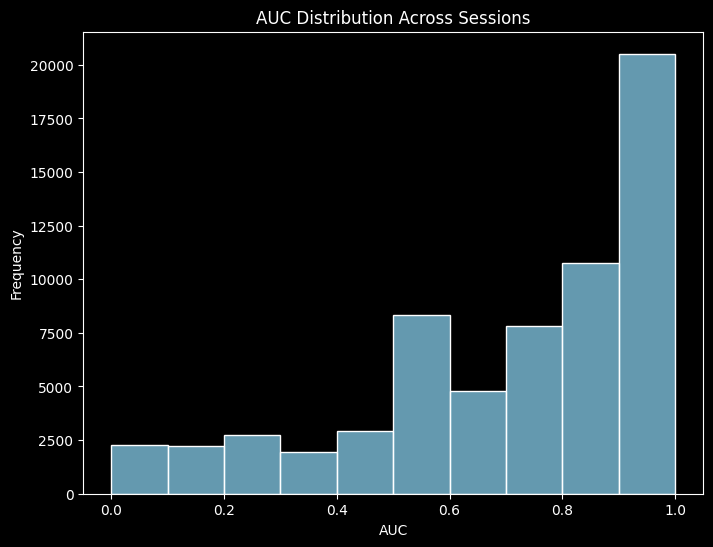

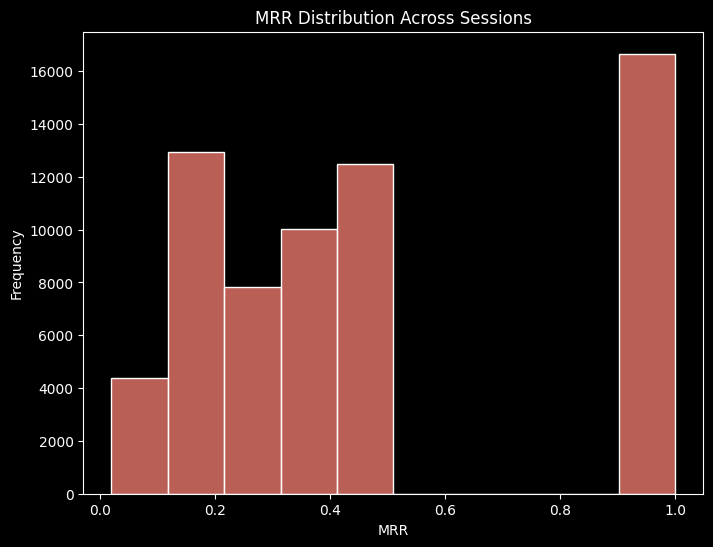

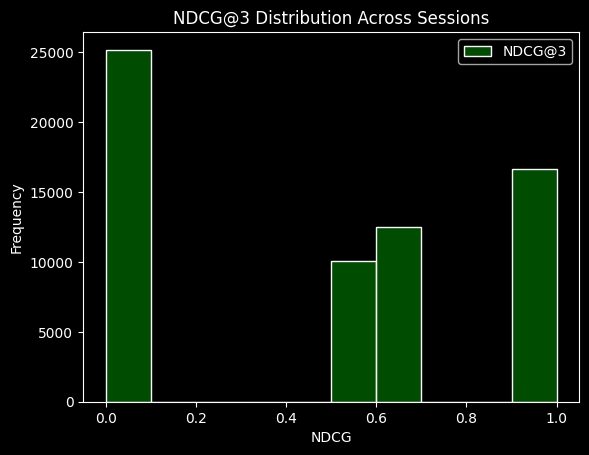

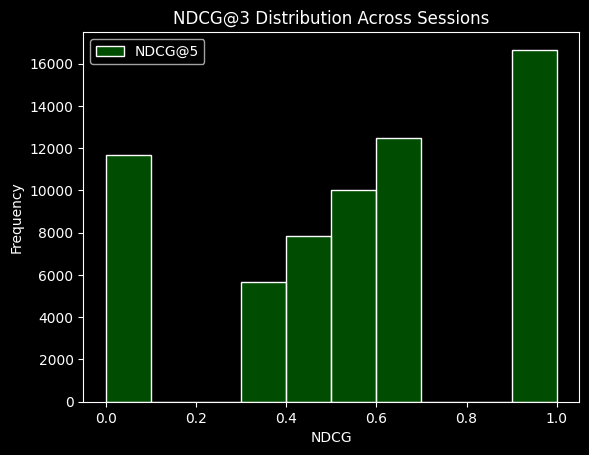

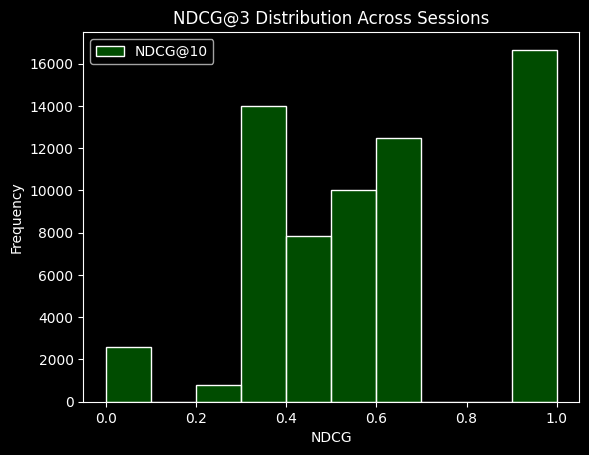

In [58]:

# Plot 2: AUC Distribution Across Sessions
plt.figure(figsize=(8, 6))
sns.histplot(results['AUC'], kde=False, color="skyblue", bins=10)
plt.title("AUC Distribution Across Sessions")
plt.xlabel("AUC")
plt.ylabel("Frequency")
plt.show()

# Plot 3: MRR Distribution
plt.figure(figsize=(8, 6))
sns.histplot(results['MRR'], kde=False, color="salmon", bins=10)
plt.title("MRR Distribution Across Sessions")
plt.xlabel("MRR")
plt.ylabel("Frequency")
plt.show()

# Plot 4: NDCG@3 
sns.histplot(results['NDCG@3'], kde=False, color="green", label="NDCG@3", bins=10, alpha=0.6)
plt.title("NDCG@3 Distribution Across Sessions")
plt.xlabel("NDCG")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# Plot 5: NDCG@5 
sns.histplot(results['NDCG@5'], kde=False, color="green", label="NDCG@5", bins=10, alpha=0.6)
plt.title("NDCG@3 Distribution Across Sessions")
plt.xlabel("NDCG")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Plot 6: NDCG@10 
sns.histplot(results['NDCG@10'], kde=False, color="green", label="NDCG@10", bins=10, alpha=0.6)
plt.title("NDCG@3 Distribution Across Sessions")
plt.xlabel("NDCG")
plt.ylabel("Frequency")
plt.legend()
plt.show()




